# First add steamer and reader functions


In [33]:
import warnings
warnings.filterwarnings('ignore')

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
import pandas as pd
import statistics
import string
import os
import re
import sys
import inspect
import numpy as np

In [34]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

def get_stem_word(text: str) -> str:
    
    stemmed_words = []
    sent_list = text.split()
    
    for word in sent_list:
        try:
            stemmed_words.append(stemmer.stem(word)) 
        except:
             stemmed_words.append(word)
    return ' '.join(stemmed_words)


In [35]:
# path for the cleaned data we are going to use
csv_path = "../cleanedPre_gl_tweeter_data.csv"

# taking a csv file path and reading a dataframe
def read_proccessed_data(csv_path: str):
    try:    
        df = pd.read_csv(csv_path)
        print("csv read")
        return df
    
    except FileNotFoundError:
        print("file not found")

# 1. Sentiment Analysis

In [36]:
pip install wordcloud


In [37]:
import pandas as pd
import sys,os
from wordcloud import STOPWORDS,WordCloud
sys.path.append(os.path.abspath(os.path.join('..')))

In [38]:
# reading the data

df = read_proccessed_data(csv_path)

csv read


In [39]:
#inspect col.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21997 entries, 0 to 21996
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          21997 non-null  object 
 1   source              21997 non-null  object 
 2   original_text       21997 non-null  object 
 3   retweet_text        0 non-null      float64
 4   sentiment           21997 non-null  int64  
 5   polarity            21997 non-null  float64
 6   subjectivity        21997 non-null  float64
 7   lang                21997 non-null  object 
 8   favorite_count      21997 non-null  int64  
 9   retweet_count       21997 non-null  int64  
 10  original_author     21997 non-null  object 
 11  followers_count     21997 non-null  int64  
 12  friends_count       21997 non-null  int64  
 13  possibly_sensitive  6190 non-null   object 
 14  hashtags            19138 non-null  object 
 15  user_mentions       18695 non-null  object 
 16  plac

In [40]:
# inspecting polarity
df['polarity']
df['polarity'].value_counts()

 0.000000    8982
-0.100000     872
 0.133333     781
 0.500000     502
 0.200000     451
             ... 
-0.900000       1
 0.088571       1
 0.140741       1
-0.004167       1
-0.021212       1
Name: polarity, Length: 917, dtype: int64

In [41]:
# sum of null values in clean text and polarity columns
text_null_sum = df['clean_text'].isnull().sum()
polarity_null_sum = df['polarity'].isnull().sum()

print(f'In clean_text column there are {text_null_sum} NULL Values')
print(f'In polarity cloumn there are {polarity_null_sum} NULL values')

In clean_text column there are 0 NULL Values
In polarity cloumn there are 0 NULL values


In [42]:
# create a model ready table
tweets_df = pd.DataFrame(columns=['clean_text', 'sentiment', 'hashtags', 'lang'])

tweets_df['sentiment'] =  df['sentiment'].to_list()
tweets_df['lang'] = df['lang'].to_list()
tweets_df['hashtags'] = df['hashtags'].to_list()
tweets_df['clean_text'] = df['clean_text'].to_list()

tweets_df.head()

,clean_text,sentiment,hashtags,lang
0,rt : extra random image (i):\n\nlets focus in ...,0,city,en
1,rt : #china's media explains the military reas...,0,china,en
2,china even cut off communication they don't an...,-1,xijinping,en
3,putin to #xijinping : i told you my friend tai...,1,xijinping,en
4,rt : i m sorry i thought taiwan was an indepen...,0,NaN,en


In [44]:
tweets_df['retweet_text'] =  tweets_df['clean_text'].astype(str)
tweets_df['clean_text']= tweets_df['clean_text'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))
tweets_df['sentiment'] =  tweets_df['sentiment'].astype(int)
tweets_df['hashtags'] = tweets_df['hashtags'].astype(str)
tweets_df['hashtags'] = tweets_df['hashtags'].apply(lambda x: x.lower())
tweets_df['hashtags']= tweets_df['hashtags'].apply(lambda x: x.translate(str.maketrans(' ', ' ', string.punctuation)))

In [45]:
tweets_df.to_csv('../data/model_ready_data.csv', index=False)
print('Model Ready Data Successfully Saved.!!!')

Model Ready Data Successfully Saved.!!!


In [46]:
tweets_df.drop(tweets_df[tweets_df['sentiment'] == -1].index, inplace=True)
tweets_df.reset_index(drop=True, inplace=True)

In [47]:
flattened_words_df = pd.DataFrame(
    [word for words_list in tweets_df['retweet_text']
    for word in words_list.split(' ')],
    columns=['word'])

flattened_words_df.head()

,word
0,rt
1,:
2,extra
3,random
4,image


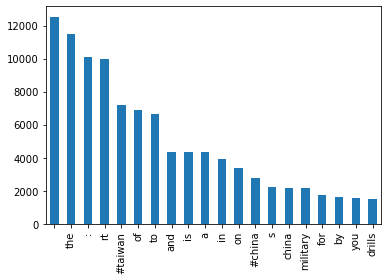

In [48]:
flattened_words_df['word'].value_counts()[:20].plot(kind='bar')


In [49]:
flattened_hashtags_df = pd.DataFrame(
    [hashtag for hashtags_list in tweets_df.hashtags
    for hashtag in hashtags_list.split(',')],
    columns=['hashtag'])

flattened_hashtags_df.drop(flattened_hashtags_df[flattened_hashtags_df['hashtag'] == ""].index, inplace=True)
flattened_hashtags_df.reset_index(drop=True, inplace=True)
flattened_hashtags_df.head()

,hashtag
0,city
1,china
2,xijinping
3,nan
4,taiwan


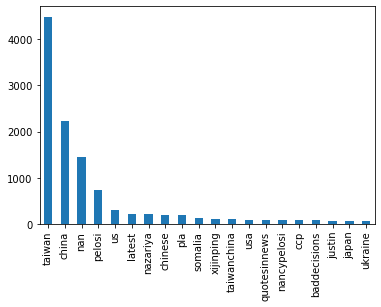

In [50]:
flattened_hashtags_df.hashtag.value_counts()[:20].plot(kind='bar')

 # 1.1 Sentimental modeling 

In [51]:
import pandas as pd
import joblib
import pickle

model_tweets = pd.read_csv('../data/model_ready_data.csv')
model_tweets = model_tweets.fillna("")
model_tweets.head()



,clean_text,sentiment,hashtags,lang,retweet_text
0,rt extra random image i\n\nlets focus in one ...,0,city,en,rt : extra random image (i):\n\nlets focus in ...
1,rt chinas media explains the military reasons...,0,china,en,rt : #china's media explains the military reas...
2,china even cut off communication they dont anw...,-1,xijinping,en,china even cut off communication they don't an...
3,putin to xijinping i told you my friend taiwa...,1,xijinping,en,putin to #xijinping : i told you my friend tai...
4,rt i m sorry i thought taiwan was an independ...,0,,en,rt : i m sorry i thought taiwan was an indepen...


In [52]:
model_tweets.shape

(21997, 5)

In [53]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from joblib import dump, load # used for saving and loading sklearn objects
from scipy.sparse import save_npz, load_npz # used for saving and loading sparse matrices
from sklearn.decomposition import NMF, LatentDirichletAllocation

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import numpy as np

In [54]:
sentiment_analysis_tweet_data = model_tweets.copy(deep=True)
sentiment_analysis_tweet_data.drop(sentiment_analysis_tweet_data[sentiment_analysis_tweet_data['sentiment'] == -1].index, inplace=True)
sentiment_analysis_tweet_data.reset_index(drop=True, inplace=True)
tweet_train = sentiment_analysis_tweet_data.iloc[:4492,]
tweet_test = sentiment_analysis_tweet_data.iloc[4493:,]

In [55]:
#unigram count
unigram_vectorizer = CountVectorizer(ngram_range=(1, 1))
unigram_vectorizer.fit(tweet_train['clean_text'].values)

CountVectorizer()

In [56]:
# creating a unigram representation of x
X_train_unigram = unigram_vectorizer.transform(tweet_train['clean_text'].values)

In [57]:
unigram_tf_idf_transformer = TfidfTransformer()
unigram_tf_idf_transformer.fit(X_train_unigram)


TfidfTransformer()

In [58]:
X_train_unigram_tf_idf = unigram_tf_idf_transformer.transform(X_train_unigram)

In [59]:
bigram_vectorizer = CountVectorizer(ngram_range=(1, 10))
bigram_vectorizer.fit(tweet_train['clean_text'].values)


CountVectorizer(ngram_range=(1, 10))

In [60]:
X_train_bigram = bigram_vectorizer.transform(tweet_train['clean_text'].values)

In [61]:
bigram_tf_idf_transformer = TfidfTransformer()
bigram_tf_idf_transformer.fit(X_train_bigram)

TfidfTransformer()

In [62]:
X_train_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_train_bigram)

In [63]:
def train_and_show_scores(X: csr_matrix, y: np.array, title: str) -> None:
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y,train_size=0.75, stratify=y
    )

    clf = SGDClassifier()
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    valid_score = clf.score(X_valid, y_valid)

    global_vars = globals()
    if(valid_score > global_vars['best_score']):
        global_vars['best_model'] = clf
        global_vars['best_model_name'] = title
        global_vars['best_score'] = valid_score

    print(f'{title}\nTrain score: {round(train_score, 2)} ; Validation score: {round(valid_score, 2)}\n')

In [64]:
y_train = tweet_train['sentiment'].values
y_train

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [65]:
best_model = ""
best_model_name = ""
best_score = 0

train_and_show_scores(X_train_unigram, y_train, 'Unigram Counts')
train_and_show_scores(X_train_unigram_tf_idf, y_train, 'Unigram Tf-Idf')
train_and_show_scores(X_train_bigram, y_train, 'Bigram Counts')
train_and_show_scores(X_train_bigram_tf_idf, y_train, 'Bigram Tf-Idf')

Unigram Counts
Train score: 1.0 ; Validation score: 0.93

Unigram Tf-Idf
Train score: 1.0 ; Validation score: 0.93

Bigram Counts
Train score: 1.0 ; Validation score: 0.93

Bigram Tf-Idf
Train score: 1.0 ; Validation score: 0.92



In [66]:
#The best Model is Unigram Tf-Idf with a Validation score of: 0.93. Therefore, run_test_using_model.

def run_test_using_model(best_model: SGDClassifier, model_type: str):
    unigram_vectorizer = CountVectorizer(ngram_range=(1, 1))
    unigram_vectorizer.fit(tweet_test['clean_text'].values)
    X_test_unigram = unigram_vectorizer.transform(tweet_test['clean_text'].values)

    bigram_vectorizer = CountVectorizer(ngram_range=(1, 2))
    bigram_vectorizer.fit(tweet_test['clean_text'].values)
    X_test_bigram = bigram_vectorizer.transform(tweet_test['clean_text'].values)

    y_test = tweet_test['sentiment'].values

    if(model_type == "Unigram Counts"):
        X_test = X_test_unigram

    elif(model_type == "Unigram Tf-Idf"):
        unigram_tf_idf_transformer = TfidfTransformer()
        unigram_tf_idf_transformer.fit(X_test_unigram)
        X_test_unigram_tf_idf = unigram_tf_idf_transformer.transform(X_test_unigram)

        X_test = X_test_unigram_tf_idf

    elif(model_type == "Bigram Counts"):
        X_test = X_test_bigram

    else:
        bigram_tf_idf_transformer = TfidfTransformer()
        bigram_tf_idf_transformer.fit(X_test_bigram)

        X_test_bigram_tf_idf = bigram_tf_idf_transformer.transform(X_test_bigram)
        X_test = X_test_bigram_tf_idf

   
    return best_model.score(X_test,y_test)

In [67]:
# Then save the generated LDA model
sgd = joblib.dump(best_model, '../models/newsentimentalmodel.jl')
print('Model Successfully Saved.!!!')

Model Successfully Saved.!!!


# 2. Topic Modeling

In [1]:
import nltk
nltk.download('stopwords')




[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\amanuel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
!pip install spicy


In [6]:
!pip install genism


ERROR: Could not find a version that satisfies the requirement genism (from versions: none)
ERROR: No matching distribution found for genism


In [4]:
# importing packages

import string
import tensorflow
#from gensim.models import CoherenceModel
#from gensim import corpora
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# function that takes a string and remove stop words

def remove_stopwords(sent: str) -> str:
    sent_list = sent.split()
    return ' '.join([word for word in sent_list if word not in STOPWORDS])